In [1]:
import sys
from pathlib import Path
import os
import h5py

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("Dietnet/")
from Dietnet.make_attributions import load_data, load_model
from Dietnet.helpers import dataset_utils as du
from Dietnet.Interpretability import graph_attribution_manager as gam
from Dietnet.helpers import mainloop_utils as mlu
from Dietnet.Interpretability import utils as utils

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device('cuda:0')

##  Load Old Version

In [2]:
root_dir = Path('/home/rochefortc/shared_disk_wd4tb/leochoii/DietNetworks_experiments/EXP4')
fold_path = root_dir / 'final_models/1000_genomes/two_classes_EUR_AFR__our_model1.0_lr-3e-05_anneal-0.999_eni-0.02'\
                       '_dni-0.02_accuracy_BN-1_Inpdrp-1.0_EmbNoise-0.0_decmode-regression_hu-100_tenc-100-100_tdec-100-100_hs-100_fold0'
adata_path = fold_path / 'additional_data.npz'

In [3]:
data = du.load_data('/home/rochefortc/shared_disk_wd4tb/leochoii/DietNetworks_experiments/EXP0/dataset.npy')
targets = torch.from_numpy(np.load(adata_path)['test_labels'][:,1])
x_test = torch.from_numpy(data['test_inputs'])
test_idx = data['test_subject_ids']

In [4]:
#  attrs file created in make_attributions.ipynb
attr_manager = gam.GraphAttributionManager()
attr_manager.set_device(device)


#attr_manager.set_agg_attributions(out.cpu().numpy())                                                         #  this is for baseline of encoded 0's
attr_manager.set_agg_attributions(np.nan_to_num(np.load(adata_path)['avg_int_grads']))                        #  this is for baseline of 0

attr_manager.set_feat_names(np.load(adata_path)['feature_names'])
attr_manager.set_label_names(np.load(adata_path)['label_names'])
attr_manager.set_labels(torch.from_numpy(np.load(adata_path)['test_labels'][:,1]))
attr_manager.set_genotypes_data(x_test)
attr_manager.set_working_dir('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments')

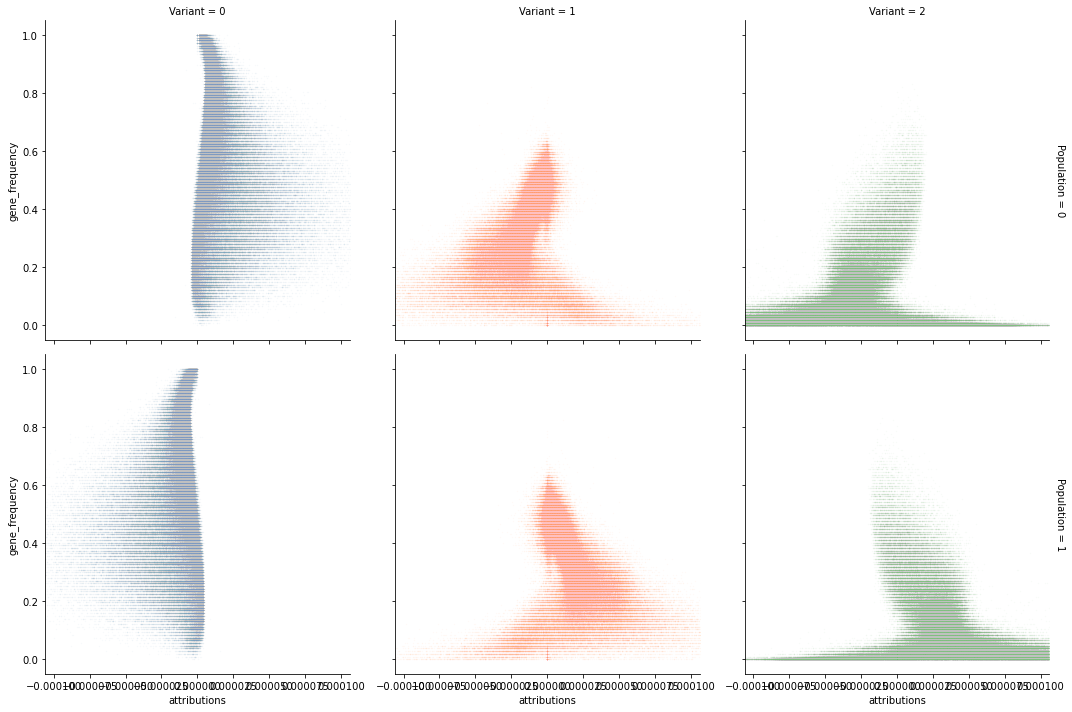

In [5]:
#attr_manager.plot_attr_vs_allele_freq(save_path='eur_vs_afr_attr_vs_allele_freq.png')
attr_manager.plot_attr_vs_gene_freq(save_path=os.path.join(attr_manager.working_dir, 'eur_vs_afr_attr_vs_genotype_freq_old.png'),
                                    global_metric=True,
                                    scatter_options={'s': 2, 'alpha': 0.03}, #{'s': 0.5, 'alpha': 0.03}
                                    plot_options={'xlim': (20*-5.3e-6, 20*5.3e-6), 'height': 5})

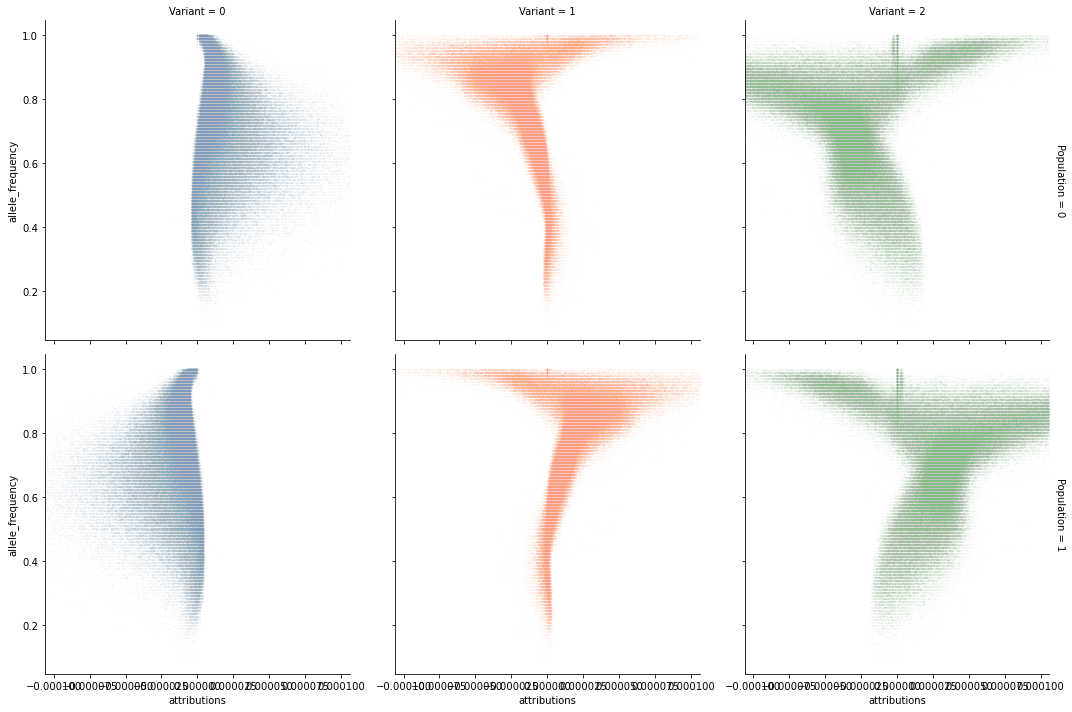

In [6]:
#attr_manager.plot_attr_vs_allele_freq(save_path='eur_vs_afr_attr_vs_allele_freq.png')
attr_manager.plot_attr_vs_allele_freq(save_path=os.path.join(attr_manager.working_dir, 'eur_vs_afr_attr_vs_allele_freq_old.png'),
                                      global_metric=True,
                                      ref=0,
                                      scatter_options={'s': 2, 'alpha': 0.03}, 
                                      plot_options={'xlim': (20*-5.3e-6, 20*5.3e-6), 'height': 5})

In [7]:
fst = np.load('/mnt/wd_4tb/shared_disk_wd4tb/leochoii/DietNetworks_experiments/Interpretation_intgrads/Two_Labels_FstVsIntgrads/fst_arrays.npz')
feat_names = np.load(adata_path)['feature_names']
#import pandas as pd
#fst2 = pd.read_csv('/mnt/wd_4tb/shared_disk_wd4tb/leochoii/DietNetworks_experiments/Interpretation_intgrads/Two_Labels_FstVsIntgrads/EUR_AFR_FST.weir.fst', sep='\t')

In [8]:
fst_feats = np.apply_along_axis(func1d=lambda x: 'chr'+str(x[0])+'pos'+str(x[1]), axis=1, arr=fst['positions'])
data_names = np.apply_along_axis(func1d=lambda x: str(x).split('_')[0][3:], axis=0, arr=feat_names.reshape(1,-1))
missing_chroms = set(data_names)-set(fst_feats)

#  get the SNP locations of the missing values and remove them from the attributions tensor
feat_names2 = [feat.decode() for feat in feat_names]
locs_to_delete = []
for mc in missing_chroms:
    locs_to_delete.extend(np.where([mc in feat for feat in feat_names2])[0].tolist())
    locs_to_keep = list(set(range(len(feat_names2)))-set(locs_to_delete)) + [0]
attr_manager.agg_attributions = attr_manager.agg_attributions[locs_to_keep,:,:]

#  make negative, so looks like Leo's
attr_manager.agg_attributions = -attr_manager.agg_attributions

#  finally, make it a pandas df so it matches expected input type of attr_manager functions
fsts = pd.DataFrame({"WEIR_AND_COCKERHAM_FST": fst['FST'][0]})

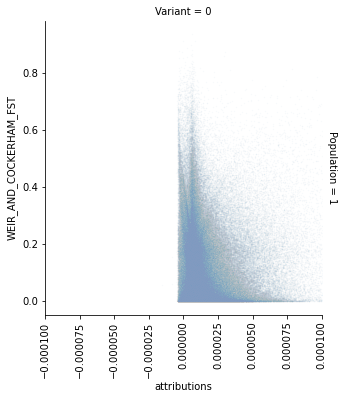

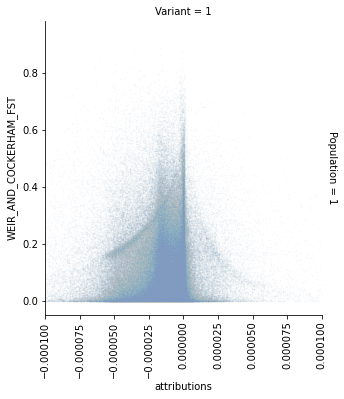

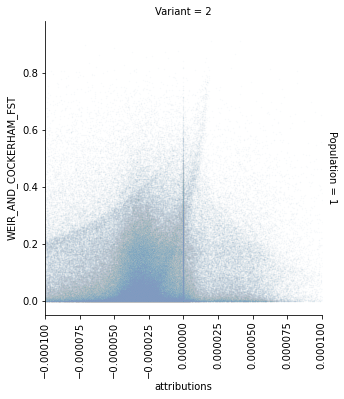

In [9]:
for var in [0,1,2]:
    fsts['Variant'] = var
    fsts['Population'] = 1
    fsts['SNP'] = fsts.index.values

    attr_manager.plot_attr_vs_snp_score(fsts, "WEIR_AND_COCKERHAM_FST", 
                                        save_path='test_pic', 
                                        scatter_options={'s': 2, 'alpha': 0.03}, 
                                        plot_options={'xlim': (-1e-4, 1e-4), 'height': 5})
    plt.xticks(rotation=90)